In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
i

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.getcwd()+'\data_220712'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data_220712


In [5]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


# Set the qubits/resonators to probe

In [6]:
qubits = [2, 1] # for eg-gf swap, always list the 2nd qubit here as the 2nd qubit in the order eg-gf

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [8]:
im = InstrumentManager()

In [10]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 6100000000.0
set power to 10.0


In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

# Pulse probe coupling spectroscopy

Sweep qubit 0 frequency after applying pi pulse to qubit 1.

In [124]:
qgspec = meas.PulseProbeCouplingSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_coupling_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 100
npts = 151

qgspec.cfg.expt = dict(
    start=qgspec.cfg.device.qubit.f_ge[qubits[0]]-span/2, # resonator frequency to be mixed up [MHz]
    # start=3600,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=500, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    pulseB=False, # Whether to apply pi pulse to qubit B
    length=15, # qubit 0 probe constant pulse length [us]
    gain=100, # qubit 0 const pulse gain
    qubits=qubits,
)

qgspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

print(qgspec.cfg)

qgspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 449.757], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2105, -1, 2686.5343, 2403.299], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 13869, 13869, 10606], 'sigma': [0.035, 0.015, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 22501, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 1000, 1000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.058197780235, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': [10, 10, 10, 10]}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'm

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\slab\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


Found peak in I at [MHz] 180.47710169195835, HWHM 0.006615421683130423
Found peak in Q at [MHz] 166.72684520043137, HWHM 0.5241291610709482


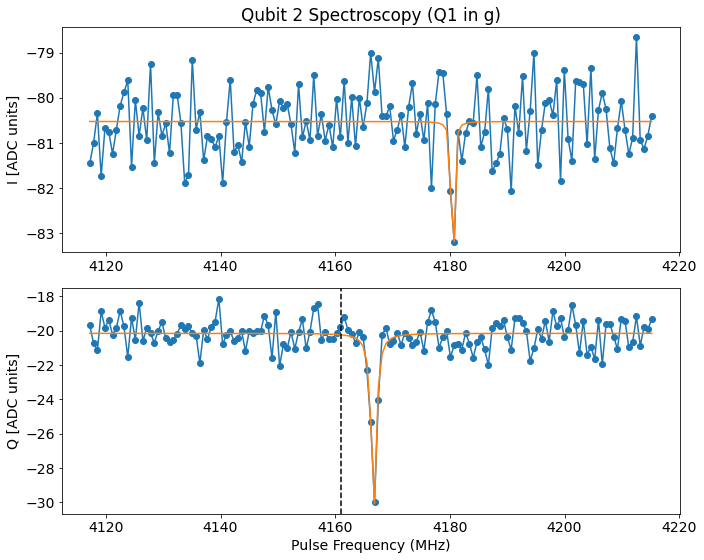

In [126]:
# # TESTING
# qgspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_coupling_spectroscopy_qubit01.h5')
# data = qgspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qgspec.display(data=data, fit=True)

qgspec.analyze(fit=True, signs=[-1, -1])
qgspec.display(fit=True, signs=[-1, -1])

In [ ]:
qgspec.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00002_qubit_EgGf_spectroscopy_qubit01.h5


# Pulse probe eg-gf spectroscopy

In [35]:
f_ge = np.array([4743.119, 3476.716, 4166.5217, 4449.757])
f_ef = np.array([4649.12, 3376.34, 4000-59.294, 4295.9599])

# print(f_ge + f_ef - f_ge[1])
print(f_ge[1] + f_ef[1] - f_ge)

[2109.937  3376.34   2686.5343 2403.299 ]


In [74]:
qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EgGf_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 50
npts = 150

qEgGfspec.cfg.expt = dict(
    # start=qEgGfspec.cfg.device.qubit.f_ge[1] - span/2, # Eg-Gf probe frequency [MHz]
    start=qEgGfspec.cfg.device.qubit.f_EgGf[qubits[0]] - span/2, # Eg-Gf probe frequency [MHz]
    # start=1900,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=500, # Number of averages per point
    rounds=40, # Number of start to finish sweeps to average over
    length=0.3, # Eg-Gf probe constant pulse length [us]
    gain=10000, # Eg-Gf const pulse gain
    qubits=qubits,
)
qEgGfspec.cfg.device.readout.relax_delay = [50]*4
# qEgGfspec.cfg.device.readout.relax_delay = [100, 100, 100, 100]
qEgGfspec.cfg.device.readout.length = [5, 5, 5, 5]

print(qEgGfspec.cfg)

qEgGfspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 456.7], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 15419, 13869, 7000], 'sigma': [0.035, 0.025, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 10922, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 1000], 'sigma': [0.1, 0, 0.17, 0.1], 'type': 'const'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.15, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': [50, 50, 50, 50], 'length': [5, 5, 5, 5]}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'],

  0%|          | 0/40 [00:00<?, ?it/s]

Found peak in avgi data (qubit A) at [MHz] 2385.6913267060277, HWHM 1.3492553813964734
Found peak in avgq data (qubit A) at [MHz] 2385.9109015453755, HWHM 1.519876571584813
Found peak in avgi data (qubit B) at [MHz] 2385.820720049024, HWHM 1.4587593183439862
Found peak in avgq data (qubit B) at [MHz] 2385.8102994986475, HWHM 1.513402820866262


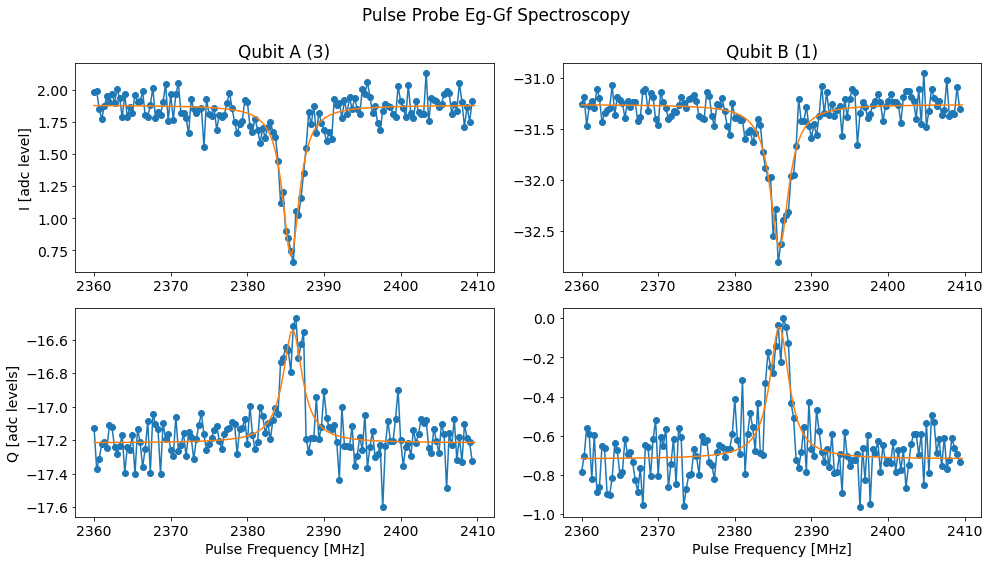

In [75]:
# # TESTING
# qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_EgGf_spectroscopy_qubit01.h5')
# data = qEgGfspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qEgGfspec.display(data=data, fit=True)

# qEgGfspec.analyze(fit=False)
sign = [[-1, 1], [-1, 1]] # [iA, qA], [iB, qB]
qEgGfspec.analyze(fit=True, sign=sign)
qEgGfspec.display(fit=True, sign=sign)

In [76]:
qEgGfspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00000_qubit_EgGf_spectroscopy_qubit31.h5


### Pulse probe EgGF power sweep

In [18]:
sweepspecEgGf = meas.PulseProbeEgGfSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_len_sweep_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_f = 75
npts_f = 150
# npts_f = 10

span_len = 20
npts_len = 10
# npts_len = 3

sweepspecEgGf.cfg.expt = dict(
    start_f=sweepspecEgGf.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # Eg-Gf probe frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_len=1,
    step_len=int(span_len/npts_len), # len step size
    expts_len=npts_len, # Number experiments stepping len from start
    reps=500,
    rounds=40, # Number averages per point
    gain=30000, # ef const pulse length [us]
    qubits=qubits,
)
sweepspecEgGf.cfg.device.readout.relax_delay = [100, 100, 100, 100]
sweepspecEgGf.cfg.device.readout.length = [5, 5, 5, 5]
sweepspecEgGf.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

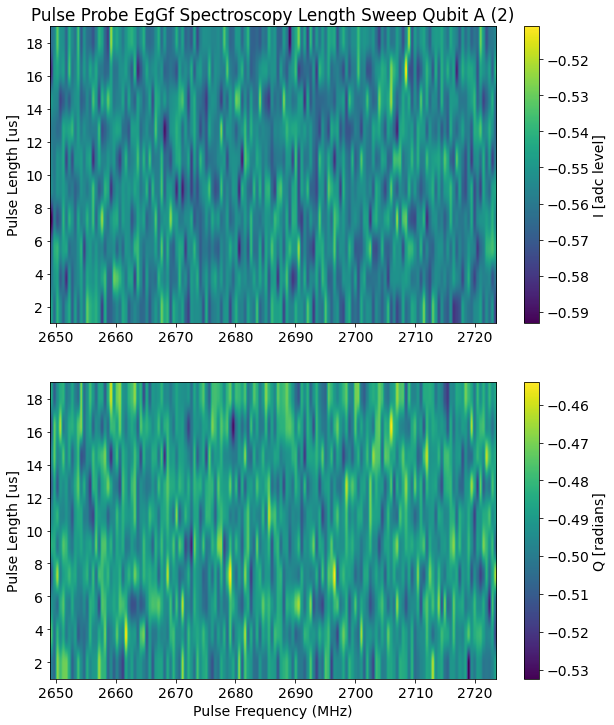

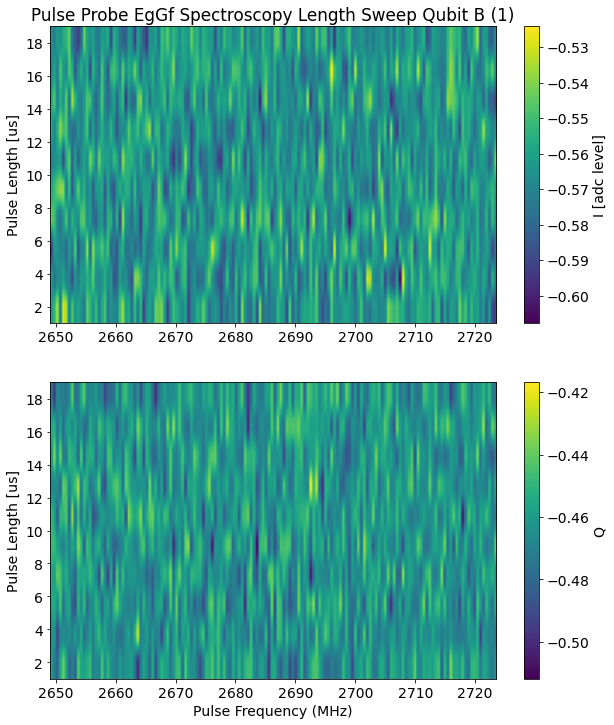

In [19]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

sweepspecEgGf.analyze()
sweepspecEgGf.display()

# Length Rabi eg-gf

In [134]:
soc.us2cycles(10)*150
soc.cycles2us(10)*100

2.8571714288571455

In [93]:
lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiEgGf.cfg.expt = dict(
    start=soc.cycles2us(5), # pulse length (sigma) [us]
    step=soc.cycles2us(5), # [us]
    # step=0.001,
    expts=100,
    reps=20000,
    gain=5000, # qubit gain [DAC units],
    pulse_type='const',
    qubits=qubits,
    singleshot=False,
)

# lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
lengthrabiEgGf.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 456.7], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 15419, 13869, 7000], 'sigma': [0.035, 0.025, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 10922, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 1000], 'sigma': [0.1, 0, 0.17, 0.1], 'type': 'const'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.15, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': [200, 300, 150, 50]}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [400

  0%|          | 0/100 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 23.333099999999998, which is out of bounds 0.07142785714285714 to 14.285571428571428. Instead init to 7.178499642857143
Attempted to init fitparam 1 to 24.747227272727272, which is out of bounds 0.07142785714285714 to 14.285571428571428. Instead init to 7.178499642857143
Attempted to init fitparam 1 to 24.040163636363637, which is out of bounds 0.07142785714285714 to 14.285571428571428. Instead init to 7.178499642857143


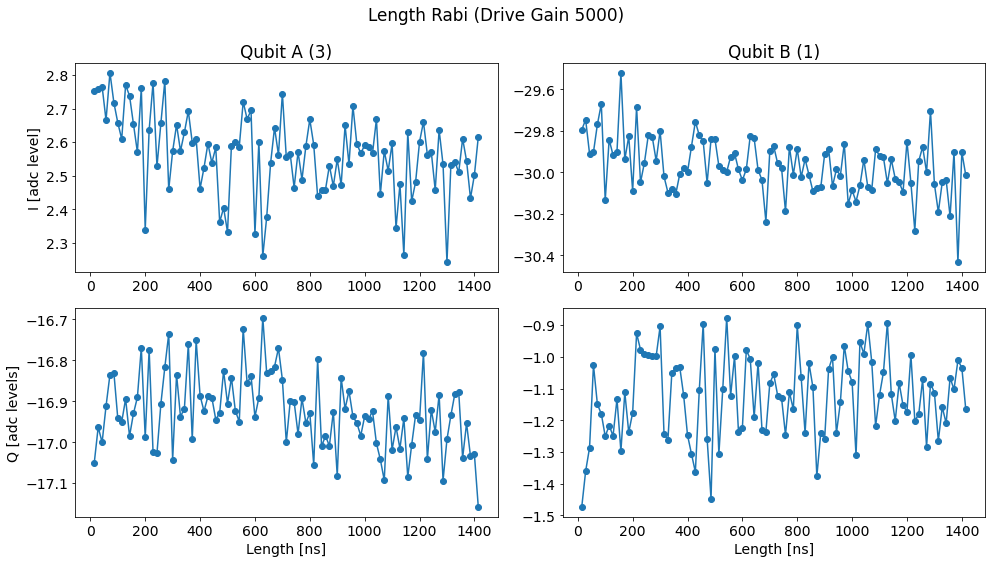

In [95]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

lengthrabiEgGf.analyze(fit=True)
lengthrabiEgGf.display(fit=False)

In [83]:
lengthrabiEgGf.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00000_length_rabi_EgGf_qubit31.h5


# Amplitude Rabi eg-gf

In [10]:
amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 15000
npts = 101
    
amprabiEgGf.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    rounds=100,
    reps=10,
    # pi_EgGf_sigma=0.600, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='const',
    qubits=qubits,
    singleshot=False,
)

# amprabiEgGf.cfg.device.readout.readout_length = [15, 15] # [us]
# amprabiEgGf.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(amprabiEgGf.cfg)

amprabiEgGf.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 456.7], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 15419, 13869, 7000], 'sigma': [0.035, 0.025, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 10922, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 10000], 'sigma': [0.1, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -804.7555447534925, -82.3, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.07, 0.04, 0.07], 'phase': [0, 0, 90, 0], 'threshold_ge': [0, -73, 0.75, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [10, 10, 10, 10], 'relax_delay': [200, 300, 150, 50]}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 

  0%|          | 0/100 [00:00<?, ?it/s]

Pi gain from avgi data (qubit A) [dac units]: 2663
	Pi/2 gain from avgi data (qubit A) [dac units]: 1331
Pi gain from avgq data (qubit A) [dac units]: 7383
	Pi/2 gain from avgq data (qubit A) [dac units]: 3691
Pi gain from avgi data (qubit B) [dac units]: 7662
	Pi/2 gain from avgi data (qubit B) [dac units]: 3831
Pi gain from avgq data (qubit B) [dac units]: 2598
	Pi/2 gain from avgq data (qubit B) [dac units]: 1299


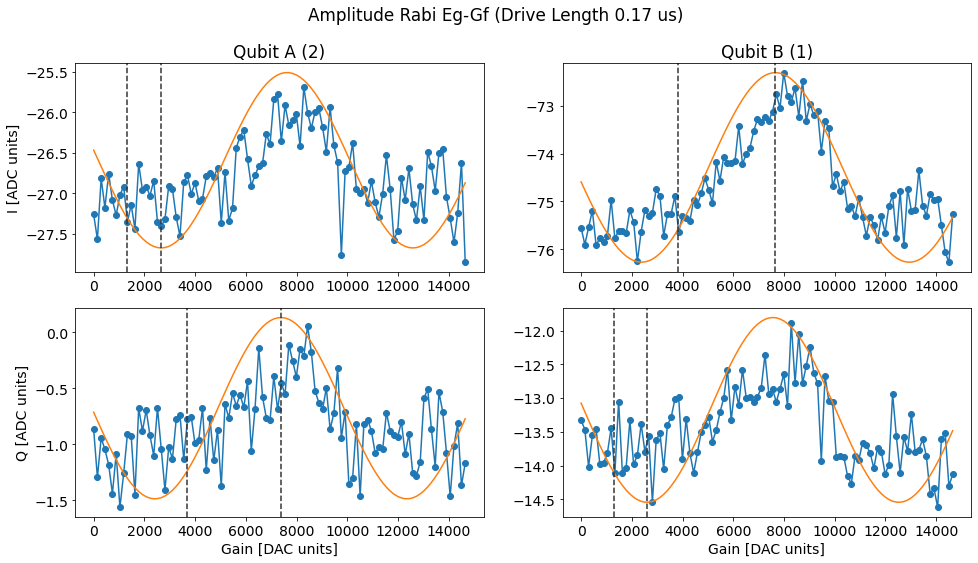

In [11]:
# # TESTING
# amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# amprabiEgGf.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = amprabiEgGf.analyze(data=temp_data, fit=True)
# amprabiEgGf.display(data=data, fit=True)

# # apply mask onto data
# temp_data = dict()
# for key, value in amprabiEgGf.data.items():
#     if len(np.shape(value)) > 1:
#         temp_data.update({key:np.array([value[0][:50], value[1][:50]])})
#     else: temp_data.update({key:value[:50]})

amprabiEgGf.analyze(data=None, fit=True)
amprabiEgGf.display(data=None, fit=True)

In [24]:
amprabiEgGf.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00001_amp_rabi_EgGf_qubit21.h5


In [149]:
prog = amprabiEgGf.prog
shot_avg = 10
threshold = amprabiEgGf.cfg.device.readout.threshold
bufi = np.array([prog.di_buf[i] for i, ch in enumerate(prog.ro_chs)])
avgi = []
for bufi_ch in bufi:
    # drop extra shots that aren't divisible into averages
    new_bufi_ch = bufi_ch[:len(bufi_ch) - (len(bufi_ch) % shot_avg)]
    # average over shots_avg number of consecutive shots
    new_bufi_ch = np.reshape(new_bufi_ch, (len(new_bufi_ch)//shot_avg, shot_avg))
    new_bufi_ch = np.average(new_bufi_ch, axis=1)
    avgi.append(new_bufi_ch)
avgi = np.array(avgi)
shots = np.array([np.heaviside(avgi[i]/prog.ro_chs[ch].length-threshold[i], 0) for i, ch in enumerate(prog.ro_chs)])

qubits = prog.cfg.expt.qubits
# get the shots for the qubits we care about
shots = np.array([shots[prog.adc_chs[q]] for q in qubits])

# data is returned as n00, n01, n10, n11 measured for the two qubits
n00 = np.sum(np.logical_and(np.logical_not(shots[0]), np.logical_not(shots[1])))
n01 = np.sum(np.logical_and(np.logical_not(shots[0]), shots[1]))
n10 = np.sum(np.logical_and(shots[0], np.logical_not(shots[1])))
n11 = np.sum(np.logical_and(shots[0], shots[1]))
print(n00, n01, n10, n11)

50 23 16 11
